In [115]:
import sys
import os 
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.sampling.sampler import get_polarisation_curve_samples, build_fixed_parameters, sample_parameters, PARAMETER_RANGES
from configuration.settings import current_density_parameters, physical_parameters, computing_parameters, operating_inputs
from model.AlphaPEM import AlphaPEM
import numpy as np
import pandas as pd

import numpy as np

def is_valid_curve(voltage_curve, tolerance=3, min_voltage=-5.0, max_voltage=1.23):
    voltage_curve = np.asarray(voltage_curve)

    # Condition 1: First value in range
    if not (0 <= voltage_curve[0] <= max_voltage):
        return False

    # Condition 2: First `tolerance` values in range
    if not np.all((0 <= voltage_curve[:tolerance]) & (voltage_curve[:tolerance] <= max_voltage)):
        return False

    # Condition 3: Monotonic decreasing
    if not np.all(np.diff(voltage_curve) <= 0):
        return False

    # Condition 4: Final value must be greater than minimum voltage allowed
    if not voltage_curve[-1] > min_voltage:
        return False

    return True

all_data = pd.read_csv('../data/raw/complete_samples_up_until_270525.csv')
lhs_data = pd.read_pickle('../data/raw/LHS_seed42_nsamples160_ndimensions16.pkl')
lhs_data2 = pd.read_pickle('../data/raw/LHS_seed42_nsamples100_ndimensions16_bounds25.pkl')

# Identify Ucell and ifc columns
ucell_cols = [col for col in all_data.columns if col.startswith('Ucell_')]
ifc_cols = [col for col in all_data.columns if col.startswith('ifc_')]

# Combine Ucell columns into lists per row
all_data['Ucell'] = all_data[ucell_cols].values.tolist()

columns = list(PARAMETER_RANGES.keys())
columns.append('Ucell')

df_combined = pd.concat([all_data[columns], lhs_data[columns], lhs_data2[columns]], axis=0, ignore_index=True)

df_combined['valid'] = df_combined['Ucell'].apply(is_valid_curve)
lhs_data['valid'] = df_combined['Ucell'].apply(is_valid_curve)
lhs_data2['valid'] = df_combined['Ucell'].apply(is_valid_curve)
all_data['valid'] = df_combined['Ucell'].apply(is_valid_curve)

data = df_combined

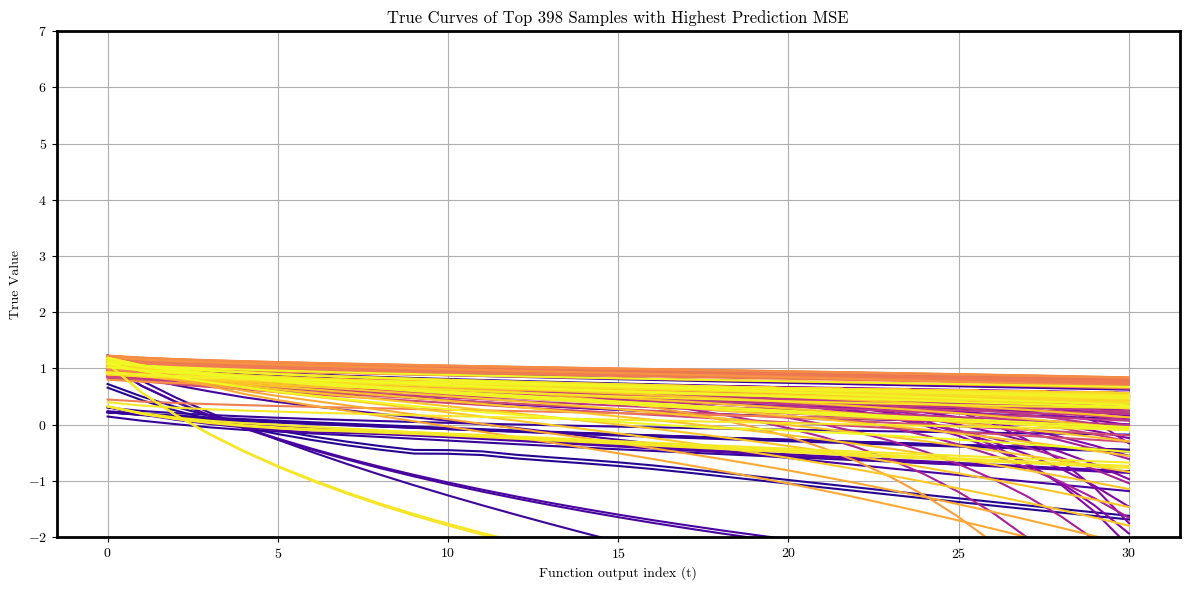

In [117]:
import matplotlib.pyplot as plt
import numpy as np

def plot_top_true_curves(Y_true, Y_pred, top_k=10):
    """
    Plot only the true curves of the top_k samples with highest MSE.
    
    Args:
        Y_true (np.array): True function outputs, shape (n_samples_total, T)
        Y_pred (np.array): Predicted function outputs, shape (n_samples_total, T)
        top_k (int): Number of worst-predicted samples to plot
    """
    # Compute per-sample MSE
    mse_per_sample = np.mean(np.abs(Y_true - Y_pred), axis=1)
    
    # Indices of top_k samples with highest MSE
    top_indices = np.argsort(mse_per_sample)[-top_k:]
    
    # Plot
    plt.figure(figsize=(12, 6))
    colors = plt.cm.plasma(np.linspace(0, 1, top_k))
    
    for idx, color in zip(top_indices, colors):
        t = np.arange(Y_true.shape[1])
        plt.plot(t, Y_true[idx], label=f'Sample {idx} (MSE={mse_per_sample[idx]:.3f})', color=color)
    
    plt.xlabel('Function output index (t)')
    plt.ylabel('True Value')
    plt.title(f'True Curves of Top {top_k} Samples with Highest Prediction MSE')
    plt.grid(True)
    plt.ylim(-2, 7)
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Example call
all_Y = np.array(data['Ucell'].tolist())
#mask_valid = np.all((all_Y[:, :15] > -3) & (all_Y[:, :15] < 5), axis=1)
mask_valid = np.array([is_valid_curve(row) for row in all_Y])
all_Y = all_Y[mask_valid]

# Split data
plot_top_true_curves(all_Y, all_Y, top_k=len(all_Y))


In [118]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.multioutput import MultiOutputRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct, WhiteKernel, ConstantKernel
from sklearn.multioutput import RegressorChain

# X: input parameters (n_samples × n_features)
# Y: output functions (n_samples × t_points)
X = np.array(data[PARAMETER_RANGES.keys()])
Y = np.array(data['Ucell'].tolist())

# Filter invalid outputs
#mask_valid = np.all((Y > 0) & (Y < 1.5), axis=1)
X = X[mask_valid]
Y = Y[mask_valid]

# Split data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Scale input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Optional: apply PCA on inputs (not outputs)
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


# Fit multi-output GP
kernel = RBF(length_scale=1.0) + WhiteKernel(noise_level=1e-3)
gp = GaussianProcessRegressor(n_restarts_optimizer=10, kernel=kernel, normalize_y=True)
multi_gp = MultiOutputRegressor(gp)
multi_gp.fit(X_train_pca, Y_train)

# Predict
Y_pred = multi_gp.predict(X_test_pca)

# Evaluate
mse_per_point = np.mean((Y_pred - Y_test) ** 2, axis=0)
mse_per_sample = np.mean((Y_pred - Y_test) ** 2, axis=1)
avg_mse = np.mean(mse_per_point)

print("Average MSE across all time points:", avg_mse)


c:\Users\dejvi\Documents\GitHub\Sensitivity-Analysis-and-Surrogate-Modeling-of-PEM-Fuel-Cells\AlphaPEM_env\Lib\site-packages\sklearn\gaussian_process\_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Average MSE across all time points: 0.03634561356214356


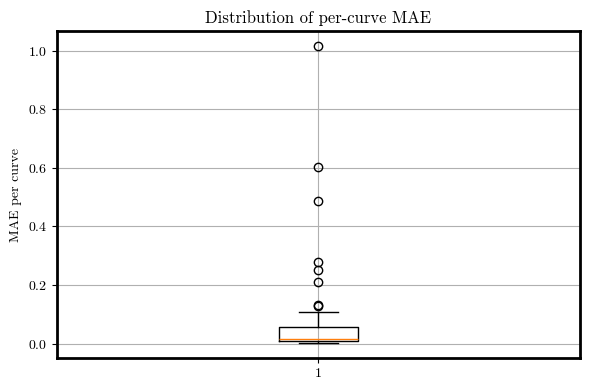

In [119]:
import numpy as np

# Shape: (n_samples, n_timepoints)
errors = Y_pred - Y_test
mae_per_curve = np.mean(np.abs(errors), axis=1)

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.boxplot(mae_per_curve, vert=True)
plt.ylabel('MAE per curve')
plt.title('Distribution of per-curve MAE')
plt.grid(True)
plt.tight_layout()
plt.show()


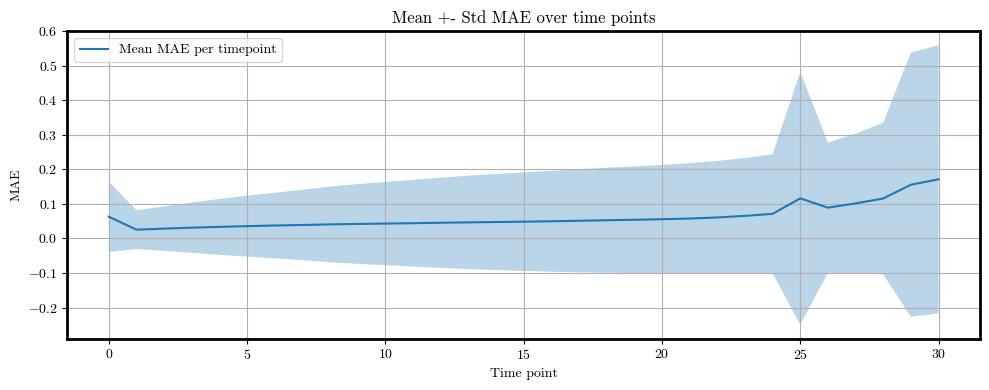

In [120]:
mae_per_t = np.mean(np.abs(errors), axis=0)
std_per_t = np.std(np.abs(errors), axis=0)

plt.figure(figsize=(10, 4))
plt.plot(mae_per_t, label='Mean MAE per timepoint')
plt.fill_between(range(len(mae_per_t)), mae_per_t - std_per_t, mae_per_t + std_per_t, alpha=0.3)
plt.xlabel('Time point')
plt.ylabel('MAE')
plt.title('Mean +- Std MAE over time points')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


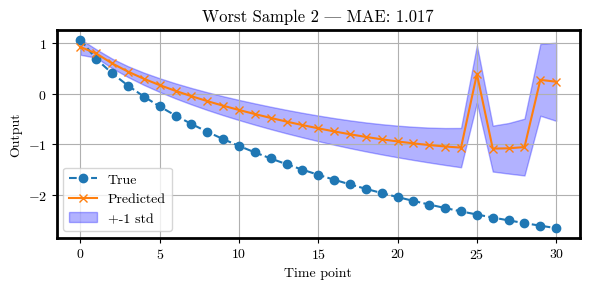

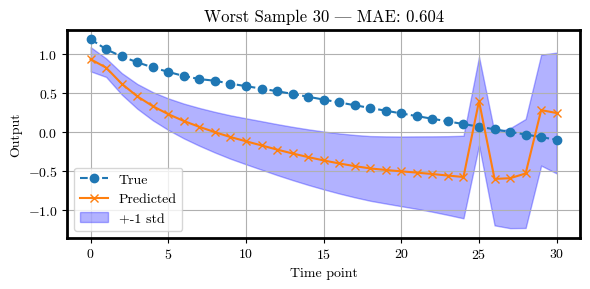

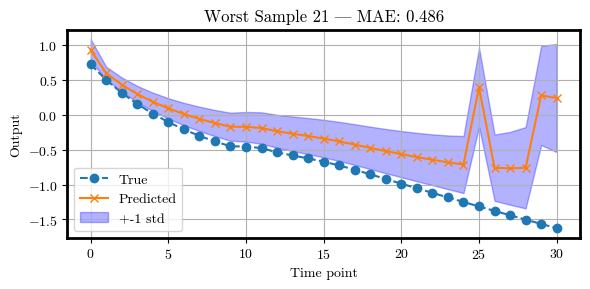

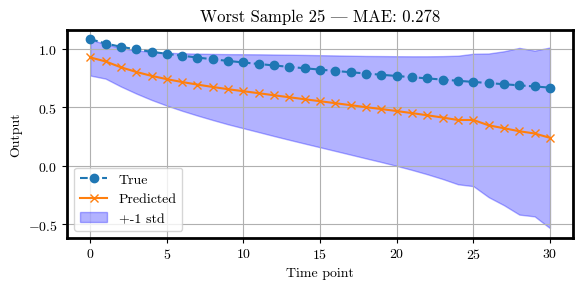

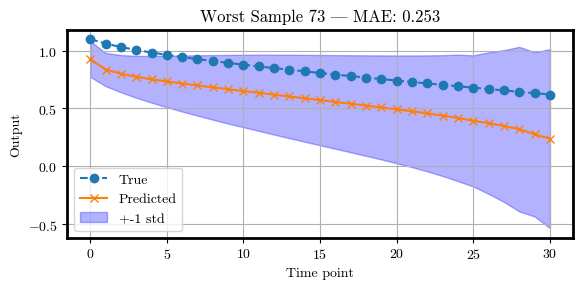

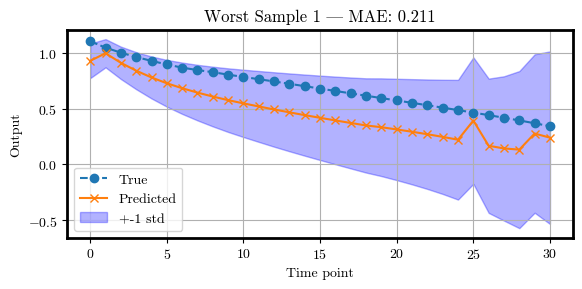

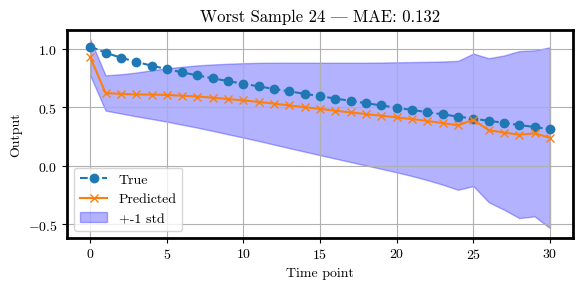

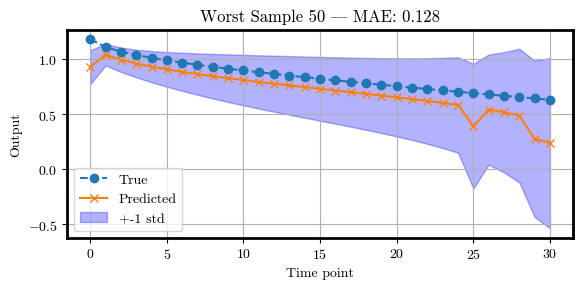

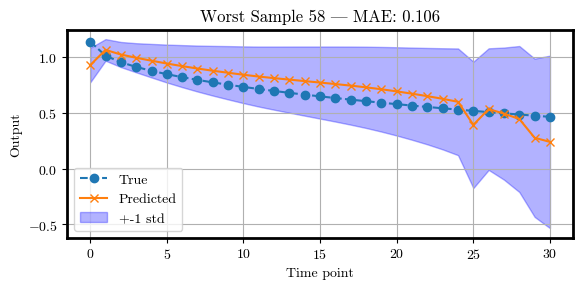

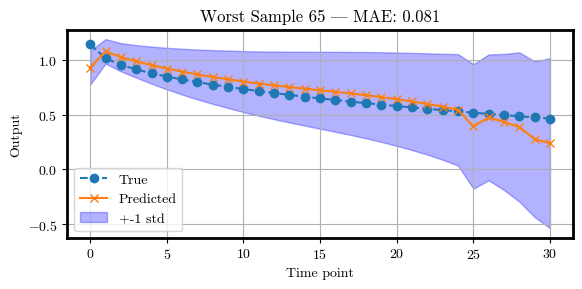

In [121]:
# Get mean and std predictions from each individual GP
Y_pred = []
Y_std = []

for estimator in multi_gp.estimators_:
    mu, std = estimator.predict(X_test_pca, return_std=True)
    Y_pred.append(mu)
    Y_std.append(std)

# Convert to (n_samples, n_outputs)
Y_pred = np.array(Y_pred).T
Y_std = np.array(Y_std).T

# MAE per test curve (you must have computed this before)
mae_per_curve = np.mean(np.abs(Y_pred - Y_test), axis=1)

# Indices of the worst curves (highest MAE)
worst_indices = np.argsort(mae_per_curve)[-10:]  # last 5 (i.e. highest errors)

# Plot with uncertainty
for idx in worst_indices[::-1]:
    plt.figure(figsize=(6, 3))
    time = np.arange(Y_test.shape[1])
    plt.plot(time, Y_test[idx], label='True', linestyle='--', marker='o')
    plt.plot(time, Y_pred[idx], label='Predicted', marker='x')
    plt.fill_between(time,
                     Y_pred[idx] - Y_std[idx],
                     Y_pred[idx] + Y_std[idx],
                     alpha=0.3, color='blue', label='+-1 std')
    plt.title(f'Worst Sample {idx} | MAE: {mae_per_curve[idx]:.3f}')
    plt.xlabel('Time point')
    plt.ylabel('Output')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
from pyDOE import lhs
import numpy as np

# Define parameter order used in training (including Pc_des!)
FEATURE_ORDER = [
    'Tfc', 'Pa_des', 'Pc_des', 'Sc', 'Phi_c_des',
    'epsilon_gdl', 'tau', 'epsilon_mc', 'epsilon_c',
    'e', 'Re', 'i0_c_ref', 'kappa_co', 'kappa_c',
    'a_slim', 'b_slim', 'a_switch'
]

# Separate continuous and categorical keys
continuous_keys = [k for k in PARAMETER_RANGES if isinstance(PARAMETER_RANGES[k], tuple)]
categorical_keys = [k for k in PARAMETER_RANGES if isinstance(PARAMETER_RANGES[k], list)]

n_candidates = 1000
n_cont = len(continuous_keys)

# Latin Hypercube Sampling for continuous parameters
lhs_samples = lhs(n_cont, samples=n_candidates)

# Rescale to actual bounds
X_continuous = np.zeros_like(lhs_samples)
for i, key in enumerate(continuous_keys):
    low, high = PARAMETER_RANGES[key]
    X_continuous[:, i] = lhs_samples[:, i] * (high - low) + low

# Handle categorical variables
X_categorical = {}
rng = np.random.default_rng(seed=42)  # For reproducibility
for key in categorical_keys:
    X_categorical[key] = rng.choice(PARAMETER_RANGES[key], size=n_candidates)

# Combine all into a dictionary
X_candidates = {}
for i, key in enumerate(continuous_keys):
    X_candidates[key] = X_continuous[:, i]
for key in categorical_keys:
    X_candidates[key] = X_categorical[key]

# Compute Pc_des = Pa_des - 2000
X_candidates['Pc_des'] = X_candidates['Pa_des'] - 2000

# Assemble the input array in the exact order used during scaler/PCA fitting
X_array = np.column_stack([X_candidates[key] for key in FEATURE_ORDER])

# 2. Preprocess (scale + PCA)
X_array_scaled = scaler.transform(X_array)
X_array_pca = pca.transform(X_array_scaled)

# 3. Predict with GP and get uncertainty
mu_list, std_list = [], []
for estimator in multi_gp.estimators_:
    mu, std = estimator.predict(X_array_pca, return_std=True)
    mu_list.append(mu)
    std_list.append(std)

# Stack std deviations and compute mean uncertainty
Y_std = np.stack(std_list, axis=1)  # shape (n_samples, n_outputs)
uncertainty = np.mean(Y_std, axis=1)

# 4. Select top-k most uncertain samples
k = 10
idx_topk = np.argsort(uncertainty)[-k:]
X_selected = X_array[idx_topk]

df_selected = pd.DataFrame(X_selected, columns=PARAMETER_RANGES.keys())
df_selected

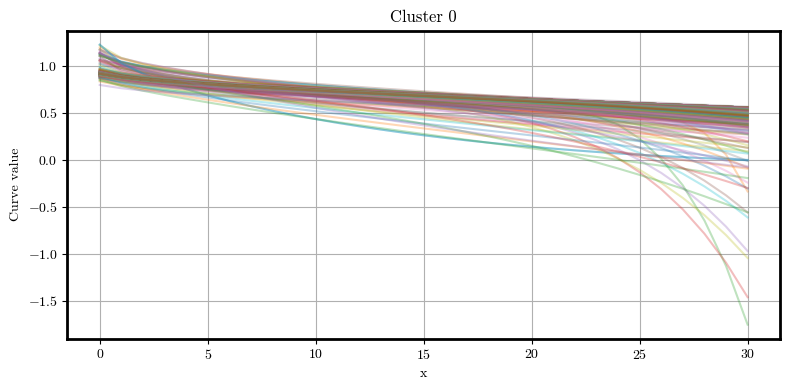

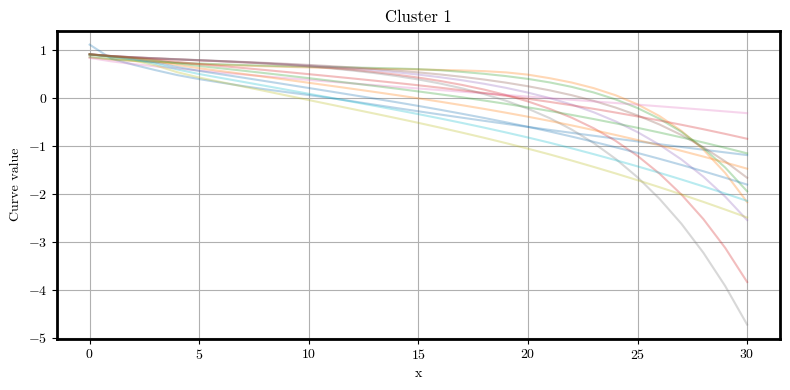

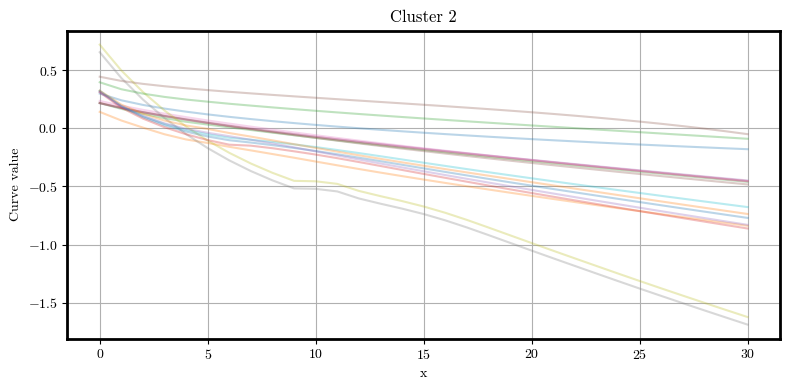

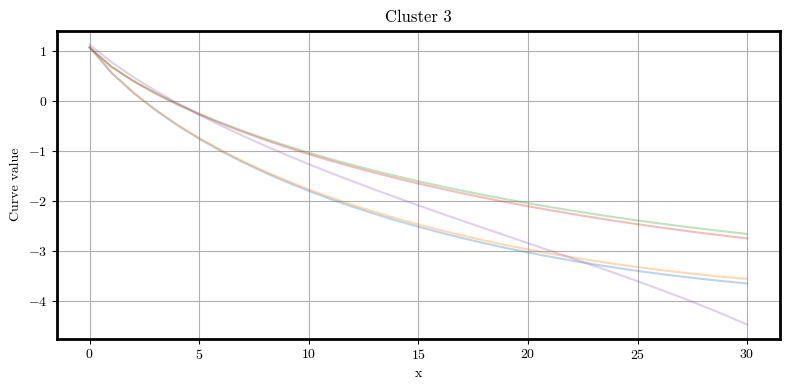

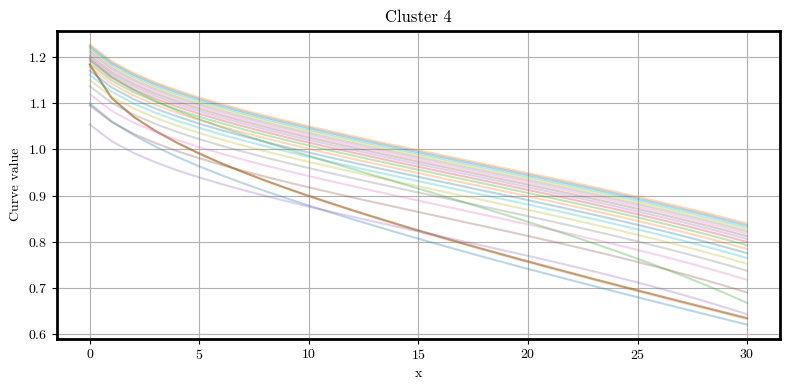

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# === Step 1: Normalize the curves ===
# Input: all_Y of shape (160, 30) — 160 curves, each with 30 y-values
scaler = StandardScaler()
curves_normalized = scaler.fit_transform(all_Y)  # normalize each curve (row-wise)

# === Step 2: Reduce dimensionality with PCA ===
# This helps with clustering by capturing the main variance directions
pca = PCA(n_components=4)
curve_features = pca.fit_transform(curves_normalized)

# === Step 3: Cluster the curves ===
k = 5  # You can set this to any number of clusters you want
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(curve_features)

# === Step 4: Visualize the clusters ===
x = list(range(0, 31))  # x-values for plotting (assumed shared across all curves)

for cluster_id in range(k):
    plt.figure(figsize=(8, 4))
    plt.title(f"Cluster {cluster_id}")
    
    # Plot all curves assigned to this cluster
    for i in range(len(all_Y)):
        if labels[i] == cluster_id:
            plt.plot(x, all_Y[i], alpha=0.3)
    
    plt.xlabel("x")
    plt.ylabel("Curve value")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
